# Timeseries plots

In [1]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-talk')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['FreeSerif']})
rc('text', usetex=False)
from matplotlib import rc
sns.set_palette("Set2")

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

#saveroot = '/home/vishwanath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures'
saveroot = 'D:/Dropbox/Apps/Overleaf/CovidSense Analysis/figures'

utils = importlib.reload(utils)

In [2]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)
    
# Region names
us_state_region_name = '../data/states_regions.csv'

with open(us_state_region_name, 'r') as f:
    region_data = f.readlines()

name2region = dict()
for state in region_data:
    name, region = state.strip().replace(r'"', '').split(',')
    name2region[name] = region


In [7]:
# Delta qids as a function of time

const = 60*60*24*10

qids_ids = [key for key in db if \
            len(db[key]['QIDS']) > 1]

qids_dict = {key:db[key] for key in qids_ids}
print(len(qids_dict))

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = int(datetime.date.today().strftime('%S'))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}

data_dict = {'delta_qids0': [],
             'delta_qids1': [],
             'delta_qids': [],
             'qids0': [],
             'qids1': [],
             'qids': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             'None': [],
             'Mental health': [],
             'Cardio-vascular': [],
             'Pulmonary': [],
             'Other health issues': [],
             'healthcare_worker': [],
             'country': []}

for key in qids_dict:
    qids = qids_dict[key]['QIDS']
    physical = qids_dict[key]['pre_physical']
    mental = qids_dict[key]['pre_mental']
    
    if 'camsr' in qids_dict[key]:
        camsr = qids_dict[key]['camsr']
    else:
        camsr = float('Nan')
        
    values = np.array(list(qids.values()))
    timestamps = np.array([float(key) for key in list(qids.keys())])*1000
    indices = np.argsort(timestamps)[::-1]

    for idx in range(indices.size-1):
        time_stamp = const*(timestamps[indices[idx]]//(const*1000))
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        
        delta_qids = values[indices[idx]] - values[indices[idx+1]]
        
        if values[indices[idx]] <= 10:
            data_dict['qids0'].append(values[indices[idx]])
            data_dict['qids1'].append(float('Nan'))
            
            data_dict['delta_qids0'].append(delta_qids)
            data_dict['delta_qids1'].append(float('Nan'))
        else:
            data_dict['qids0'].append(float('Nan'))
            data_dict['qids1'].append(values[indices[idx]])
            
            data_dict['delta_qids0'].append(float('Nan'))
            data_dict['delta_qids1'].append(delta_qids)
        
        data_dict['qids'].append(values[indices[idx]])
        data_dict['delta_qids'].append(delta_qids)
            
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(qids_dict[key]['gender'])
        data_dict['healthcare_worker'].append(qids_dict[key]['healthcare_worker'])
        data_dict['country'].append(qids_dict[key]['country'])

        if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
            len(set(conversion_dict['None']).intersection(mental)) > 0:
            data_dict['None'].append(1)
            data_dict['Mental health'].append(0)
            data_dict['Cardio-vascular'].append(0)
            data_dict['Pulmonary'].append(0)
            data_dict['Other health issues'].append(0)
        else:
            data_dict['None'].append(0)
            if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
                data_dict['Mental health'].append(1)
            else:
                data_dict['Mental health'].append(0)
            for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
                if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                    data_dict[condition_name].append(1)
                else:
                    data_dict[condition_name].append(0)
                    
data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')

740


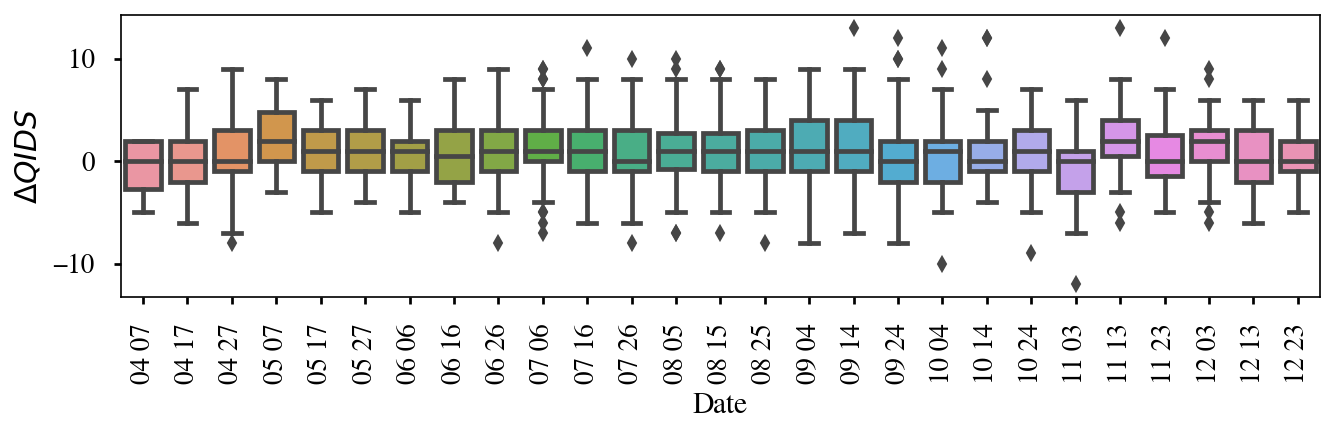

In [4]:
# Do bar plots for Delta QIDS
fig = plt.figure(dpi=150, figsize=(9, 3))
#sns.boxplot(x='timestring', y='delta_qids0', data=data_pd)
sns.boxplot(x='timestring', y='delta_qids1', data=data_pd)
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('$\Delta QIDS$')
plt.tight_layout()
plt.savefig('%s/delta_qids.pdf'%saveroot)
plt.show()

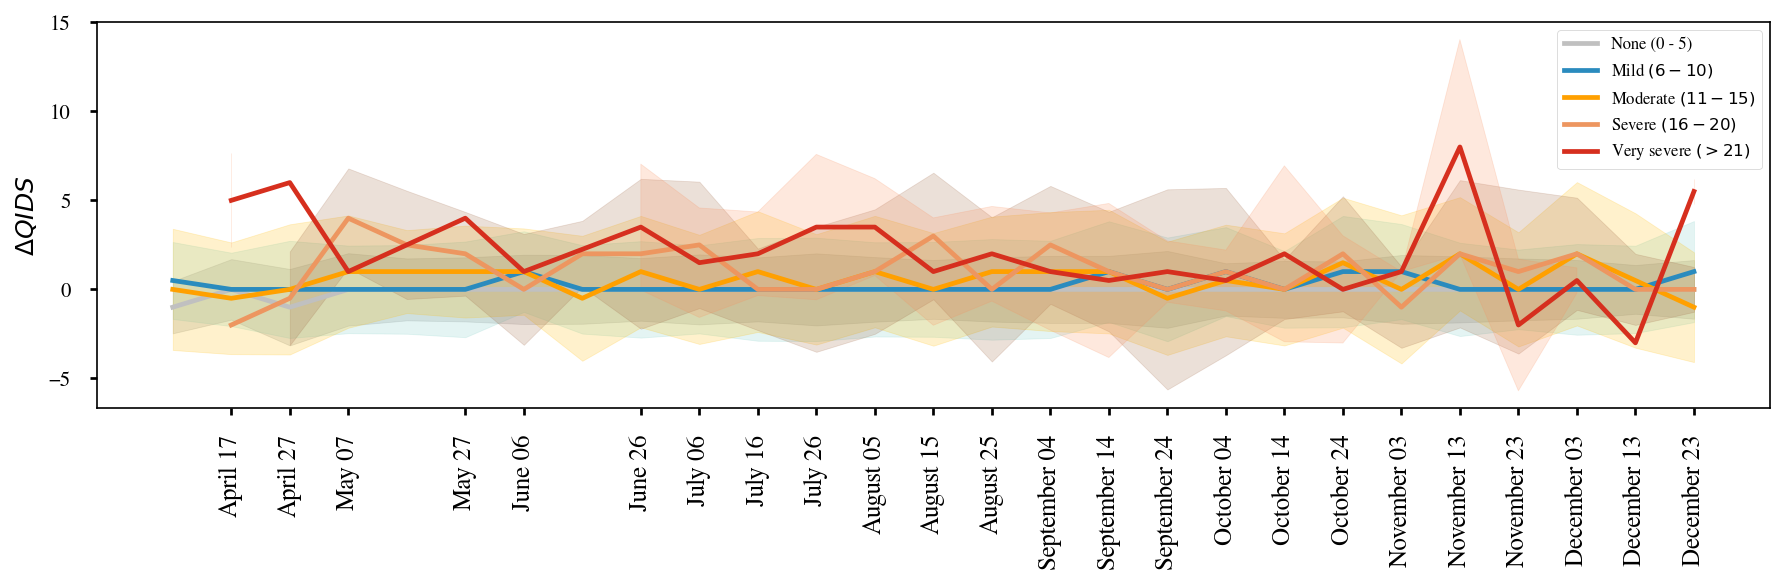

In [24]:
fontsize = 12

fig, ax, init = utils.plot_timeseries(data_pd[data_pd['qids'] <= 5 ], 'delta_qids', palette='gray', label='None $(0 - 5)$')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['qids'] > 5)*(data_pd['qids'] <= 10) ], 'delta_qids', fig=fig, ax=ax, palette='GnBu', label='Mild $(6 - 10)$')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['qids'] > 10)*(data_pd['qids'] <= 15) ], 'delta_qids', fig=fig, ax=ax, palette='Wistia', label='Moderate $(11 - 15)$')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['qids'] > 15)*(data_pd['qids'] <= 20) ], 'delta_qids', fig=fig, ax=ax, palette='copper', label='Severe $(16 - 20)$')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['qids'] > 20)*(data_pd['qids'] <= 30) ], 'delta_qids', fig=fig, ax=ax, palette='OrRd', label='Very severe $(> 21)$')

plt.xticks(fontsize=fontsize)
plt.ylabel('$\Delta QIDS$', fontsize=fontsize)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('%s/delta_qids_separated.pdf'%saveroot)
plt.show()

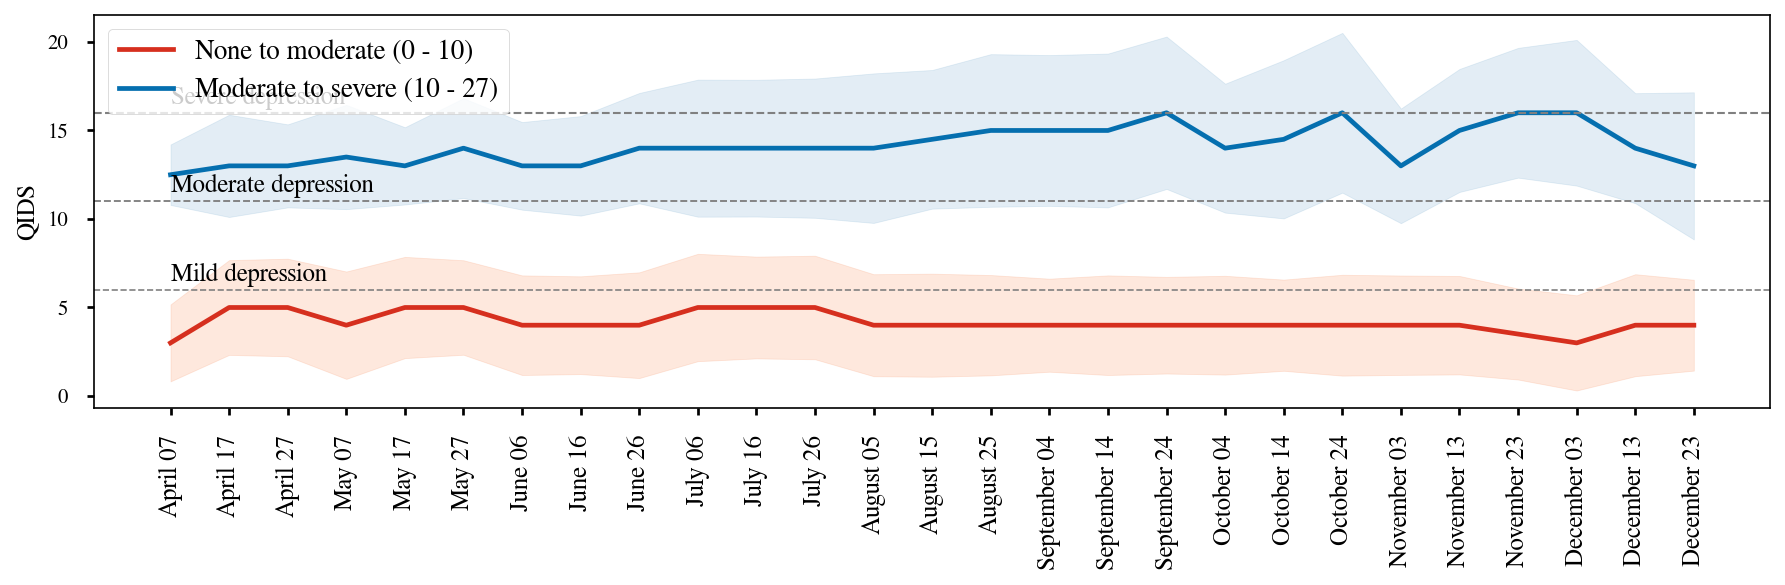

In [6]:
# QIDS averaging a la Ashok
utils = importlib.reload(utils)
fontsize = 12

fig, ax, init = utils.plot_timeseries(data_pd[['qids0', 'timestamp', 'nresponses']].dropna(),
                                'qids0', palette='OrRd', label='None to moderate (0 - 10)')
fig, ax, init = utils.plot_timeseries(data_pd[['qids1', 'timestamp', 'nresponses']].dropna(),
                                'qids1', fig=fig, ax=ax, palette='PuBu', label='Moderate to severe (10 - 27)')

# Add horizontal lines differentiating into various zones
plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
plt.annotate('Mild depression', xy=(init, 6.5), fontsize=fontsize)

plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
plt.annotate('Moderate depression', xy=(init, 11.5), fontsize=fontsize)

plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
plt.annotate('Severe depression', xy=(init, 16.5), fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.ylabel('QIDS', fontsize=fontsize)
plt.legend()
plt.tight_layout()
plt.savefig('%s/qids_separated.pdf'%saveroot)
plt.show()


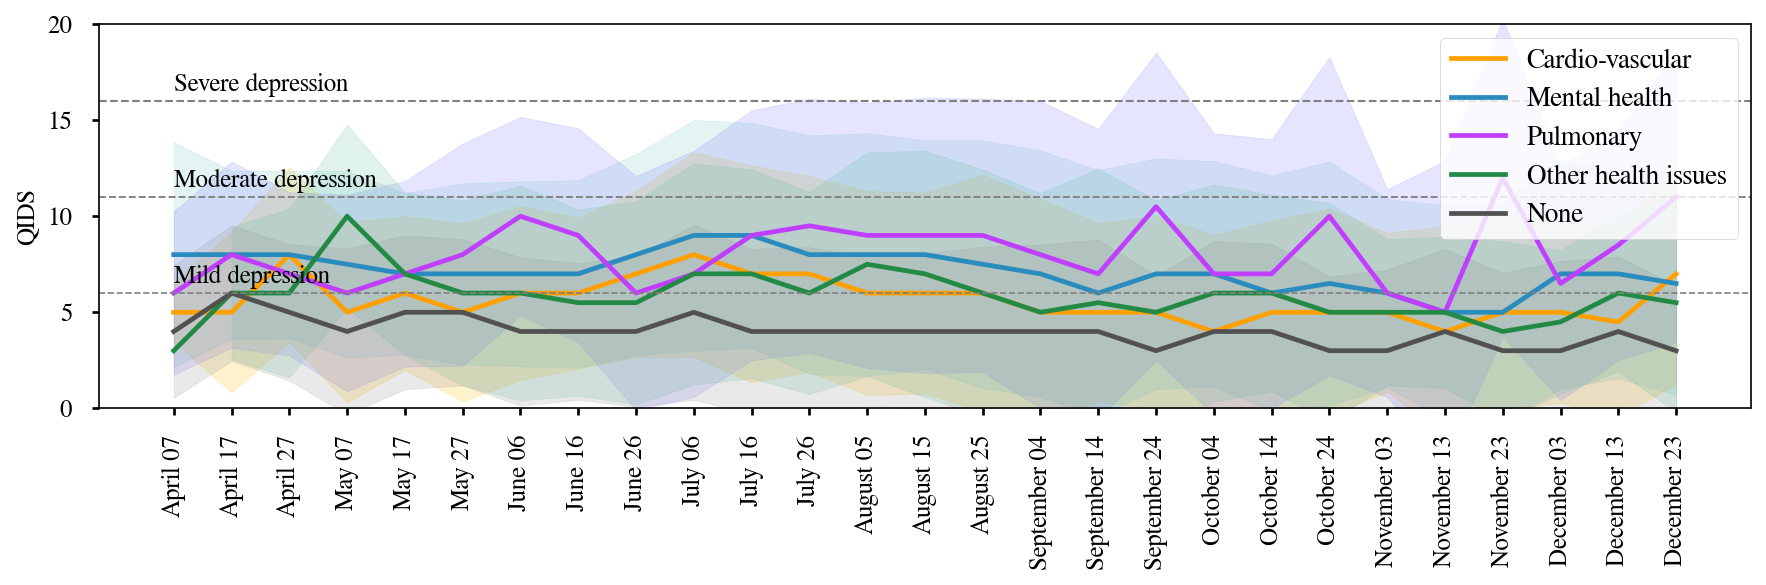

In [7]:
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Cardio-vascular'] == 1],
                                'qids', palette='Wistia', label='Cardio-vascular')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Mental health'] == 1],
                                'qids', fig=fig, ax=ax, palette='GnBu', label='Mental health')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Pulmonary'] == 1],
                                'qids', fig=fig, ax=ax, palette='cool', label='Pulmonary')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Other health issues'] == 1],
                                'qids', fig=fig, ax=ax, palette='BuGn', label='Other health issues')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['None'] == 1],
                                'qids', fig=fig, ax=ax, palette='Greys', label='None')

# Add horizontal lines differentiating into various zones
plt.axhline(y=6.0, linestyle='--', color='gray', linewidth=0.8)
plt.annotate('Mild depression', xy=(init, 6.5), fontsize=fontsize)

plt.axhline(y=11.0, linestyle='--', color='gray', linewidth=0.9)
plt.annotate('Moderate depression', xy=(init, 11.5), fontsize=fontsize)

plt.axhline(y=16.0, linestyle='--', color='gray', linewidth=1.0)
plt.annotate('Severe depression', xy=(init, 16.5), fontsize=fontsize)
plt.ylim([0, 20])

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc='upper right')
plt.ylabel('QIDS', fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/qids_preexisting.pdf'%saveroot)
plt.show()

[ 0  5 10 15 20 27] [0.54382022 0.32621723 0.09588015 0.02659176 0.00749064]


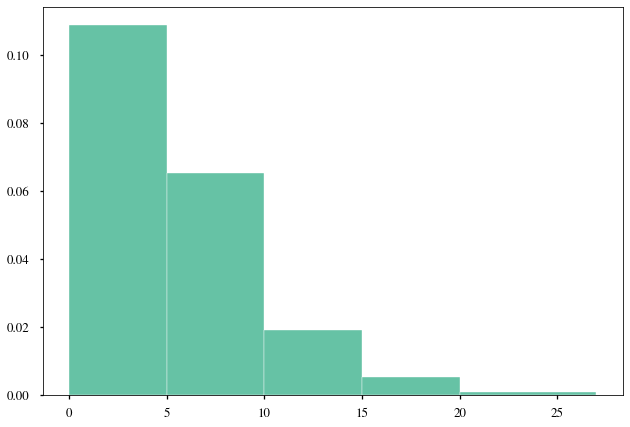

In [60]:
qids_mental = data_pd[data_pd['None'] == 1]['qids'].to_numpy()

vals, bins = np.histogram(qids_mental, bins=[0, 5, 10, 15, 20, 27])
print(bins, vals/vals.sum())
plt.hist(qids_mental, bins=[0, 5, 10, 15, 20, 27], ec='white', density=True)
plt.show()


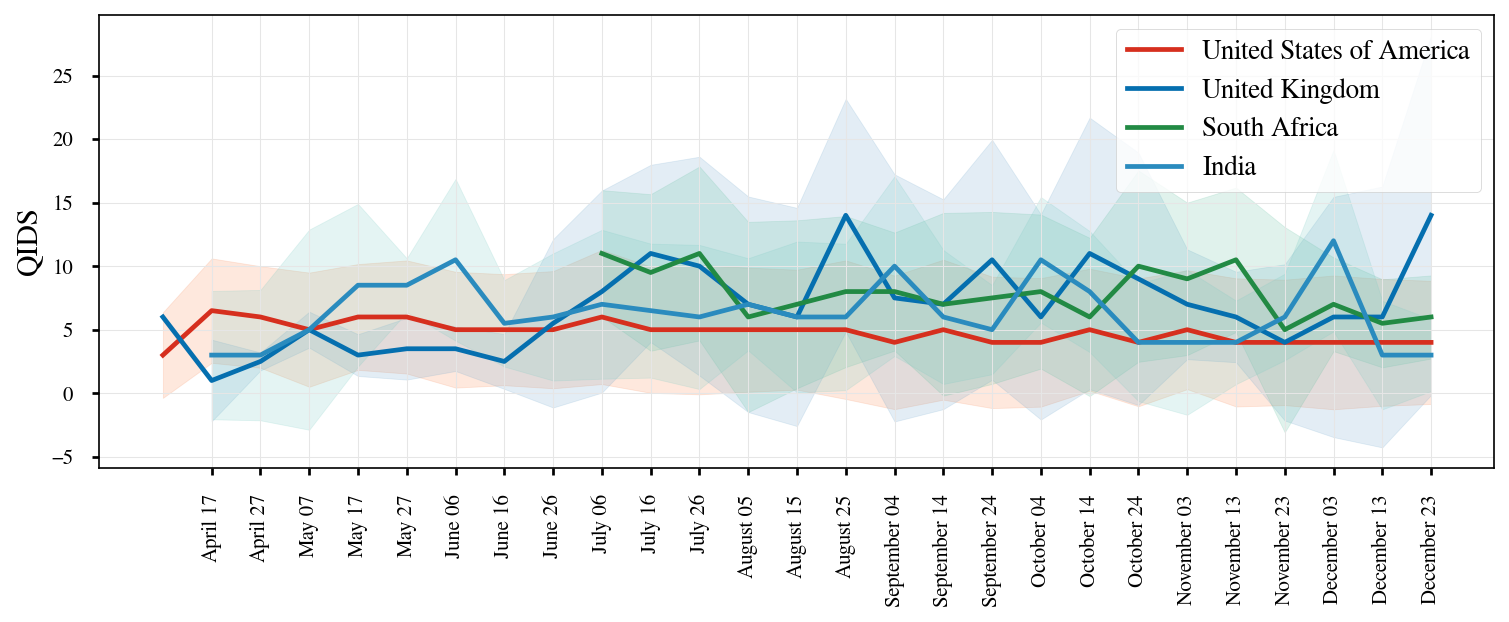

In [64]:
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['country'] == 'United States of America'],
                                'qids', palette='OrRd', label='United States of America')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['country'] == 'United Kingdom'],
                                'qids', fig=fig, ax=ax, palette='PuBu', label='United Kingdom')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['country'] == 'South Africa'],
                                'qids', fig=fig, ax=ax, palette='BuGn', label='South Africa')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['country'] == 'India'],
                                'qids', fig=fig, ax=ax, palette='GnBu', label='India')

plt.ylabel('QIDS')
plt.grid(color=(0.9, 0.9, 0.9), linewidth=0.5)
plt.savefig('%s/qids_per_country.pdf'%saveroot)
plt.legend()
plt.show()

In [8]:
# More authentic results -- hypothesis testing
qids1 = np.array(data_pd[data_pd['None'] == 0]['qids'])
qids2 = np.array(data_pd[data_pd['None'] == 1]['qids'])

mw_stat, mw_pval = stats.mannwhitneyu(qids1, qids2, alternative='greater')
tt_stat, tt_pval = stats.ttest_ind(qids1, qids2, equal_var=False)
    
print('With: %.2f +/- %.2f'%(qids1.mean(), np.sqrt(qids1.var())))
print('Without: %.2f +/- %.2f'%(qids2.mean(), np.sqrt(qids2.var())))
    
print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
print('t-test: stat: %.2f; pval: %e'%(tt_stat, tt_pval))

With: 7.56 +/- 5.46
Without: 5.01 +/- 4.14
Mann-Whitney U: stat: 6366686.50; pval: 0.000000
t-test: stat: 21.24; pval: 8.861665e-97


In [8]:
# Self reported mood
const = 60*60*24*10

qids_ids = [key for key in db if \
            len(db[key]['A']) > 1]
            #db[key]['healthcare_worker']]

mood_dict = {key:db[key] for key in qids_ids}
print(len(mood_dict))

data_dict = {'mood': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             'country': [],
             'healthcare_worker': [],
             'camsr': [],
             #'compensation': [],
             #'substance': [],
             #'sleep_without_substance': [],
             'news': [],
             'None': [],
             'Mental health': [],
             'Pulmonary': [],
             'Cardio-vascular': [],
             'Other health issues': []}

for key in mood_dict:
    A_panels = mood_dict[key]['A']
    physical = mood_dict[key]['pre_physical']
    mental = mood_dict[key]['pre_mental']
    
    camsr = float('Nan')
    for idx in range(10):
        if 'camsr%d'%idx in mood_dict[key]:
            camsr = mood_dict[key]['camsr%d'%idx]

    for A_panel in A_panels:
        time_stamp = const*(A_panel['timestamp']//const)
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        data_dict['mood'].append(A_panel['mood'])
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(mood_dict[key]['gender'])
        data_dict['country'].append(mood_dict[key]['country'])
        data_dict['healthcare_worker'].append(mood_dict[key]['healthcare_worker'])
        data_dict['camsr'].append(camsr)

        if 'news_mental_health' in A_panel:
            data_dict['news'].append(A_panel['news_mental_health'])
        else:
            data_dict['news'].append(float('nan'))
        
        if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
            len(set(conversion_dict['None']).intersection(mental)) > 0:
            data_dict['None'].append(1)
            data_dict['Mental health'].append(0)
            data_dict['Cardio-vascular'].append(0)
            data_dict['Pulmonary'].append(0)
            data_dict['Other health issues'].append(0)
        else:
            data_dict['None'].append(0)
            if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
                data_dict['Mental health'].append(1)
            else:
                data_dict['Mental health'].append(0)
            for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
                if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                    data_dict[condition_name].append(1)
                else:
                    data_dict[condition_name].append(0)

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')
print(data_pd.dropna().head())


594
      mood  nresponses     timestamp timestring timestring2  gender  \
6263     2           1  1.589760e+09      05 17      May 17  female   
6279     4           1  1.589760e+09      05 17      May 17    male   
6239     2           1  1.589760e+09      05 17      May 17  female   
6217     3           1  1.589760e+09      05 17      May 17    male   
6157     3           1  1.589760e+09      05 17      May 17  female   

                       country  healthcare_worker  camsr  news  None  \
6263                    France                  0    3.0   0.0     0   
6279  United States of America                  0    4.0   1.0     0   
6239  United States of America                  0    4.0   3.0     0   
6217  United States of America                  0    3.0   1.0     0   
6157                    Ελλάδα                  0    3.0   1.0     1   

      Mental health  Pulmonary  Cardio-vascular  Other health issues  
6263              0          0                1                  

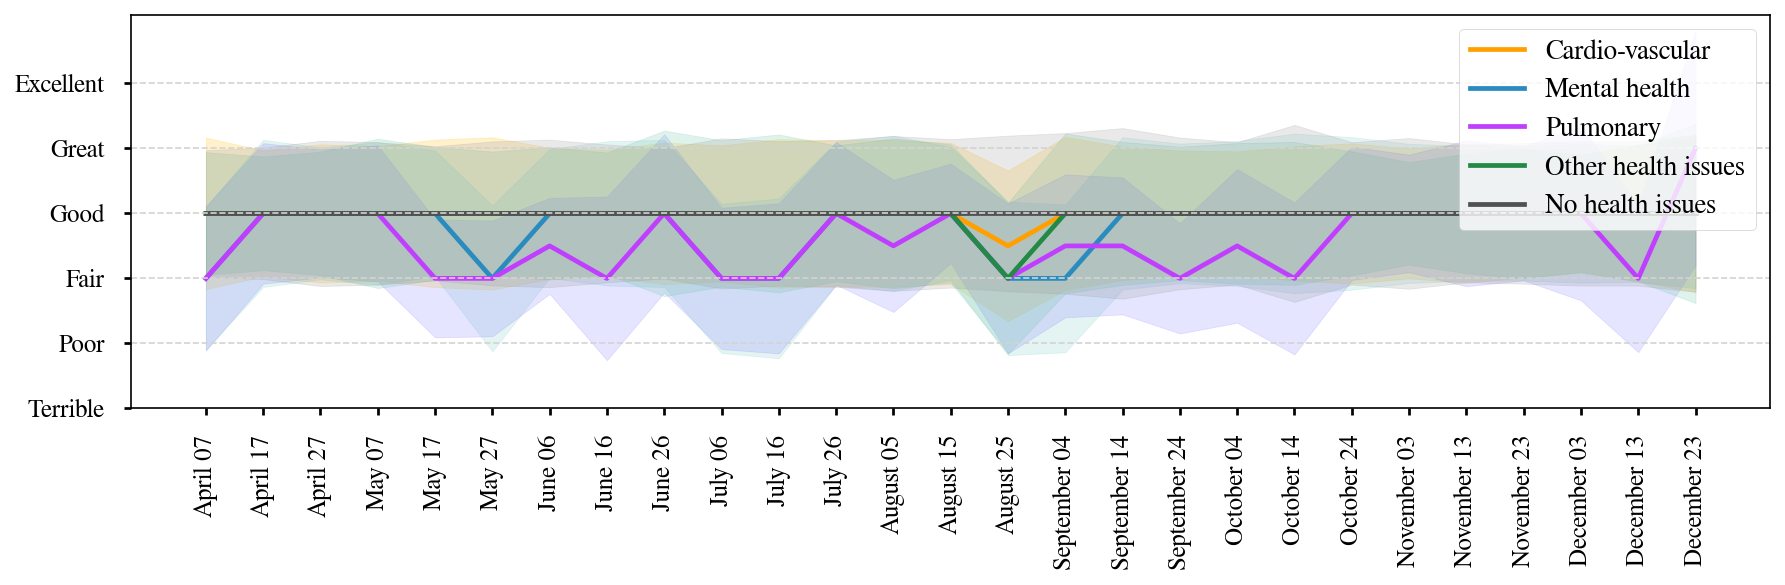

In [9]:
utils = importlib.reload(utils)
varname = 'mood'

fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Cardio-vascular'] == 1],
                                varname, palette='Wistia', label='Cardio-vascular')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Mental health'] == 1],
                                varname, fig=fig, ax=ax, palette='GnBu', label='Mental health')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Pulmonary'] == 1],
                                varname, fig=fig, ax=ax, palette='cool', label='Pulmonary')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['Other health issues'] == 1],
                                varname, fig=fig, ax=ax, palette='BuGn', label='Other health issues')
fig, ax, init = utils.plot_timeseries(data_pd[data_pd['None'] == 1],
                                varname, fig=fig, ax=ax, palette='Greys', label='No health issues')

plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=3.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=4.0, linestyle='--', color='lightgray', linewidth=0.8)
plt.axhline(y=5.0, linestyle='--', color='lightgray', linewidth=0.8)

plt.xticks(fontsize=fontsize)
plt.yticks([0, 1, 2, 3, 4, 5], ['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'], fontsize=fontsize)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('%s/%s_pre_existing.pdf'%(saveroot, varname))
plt.show()


With: 3.79 +/- 1.03
Without: 2.49 +/- 0.99
Mann-Whitney U: stat: 7854.50; pval: 0.000000
t-test: stat: 6.47; pval: 0.000000


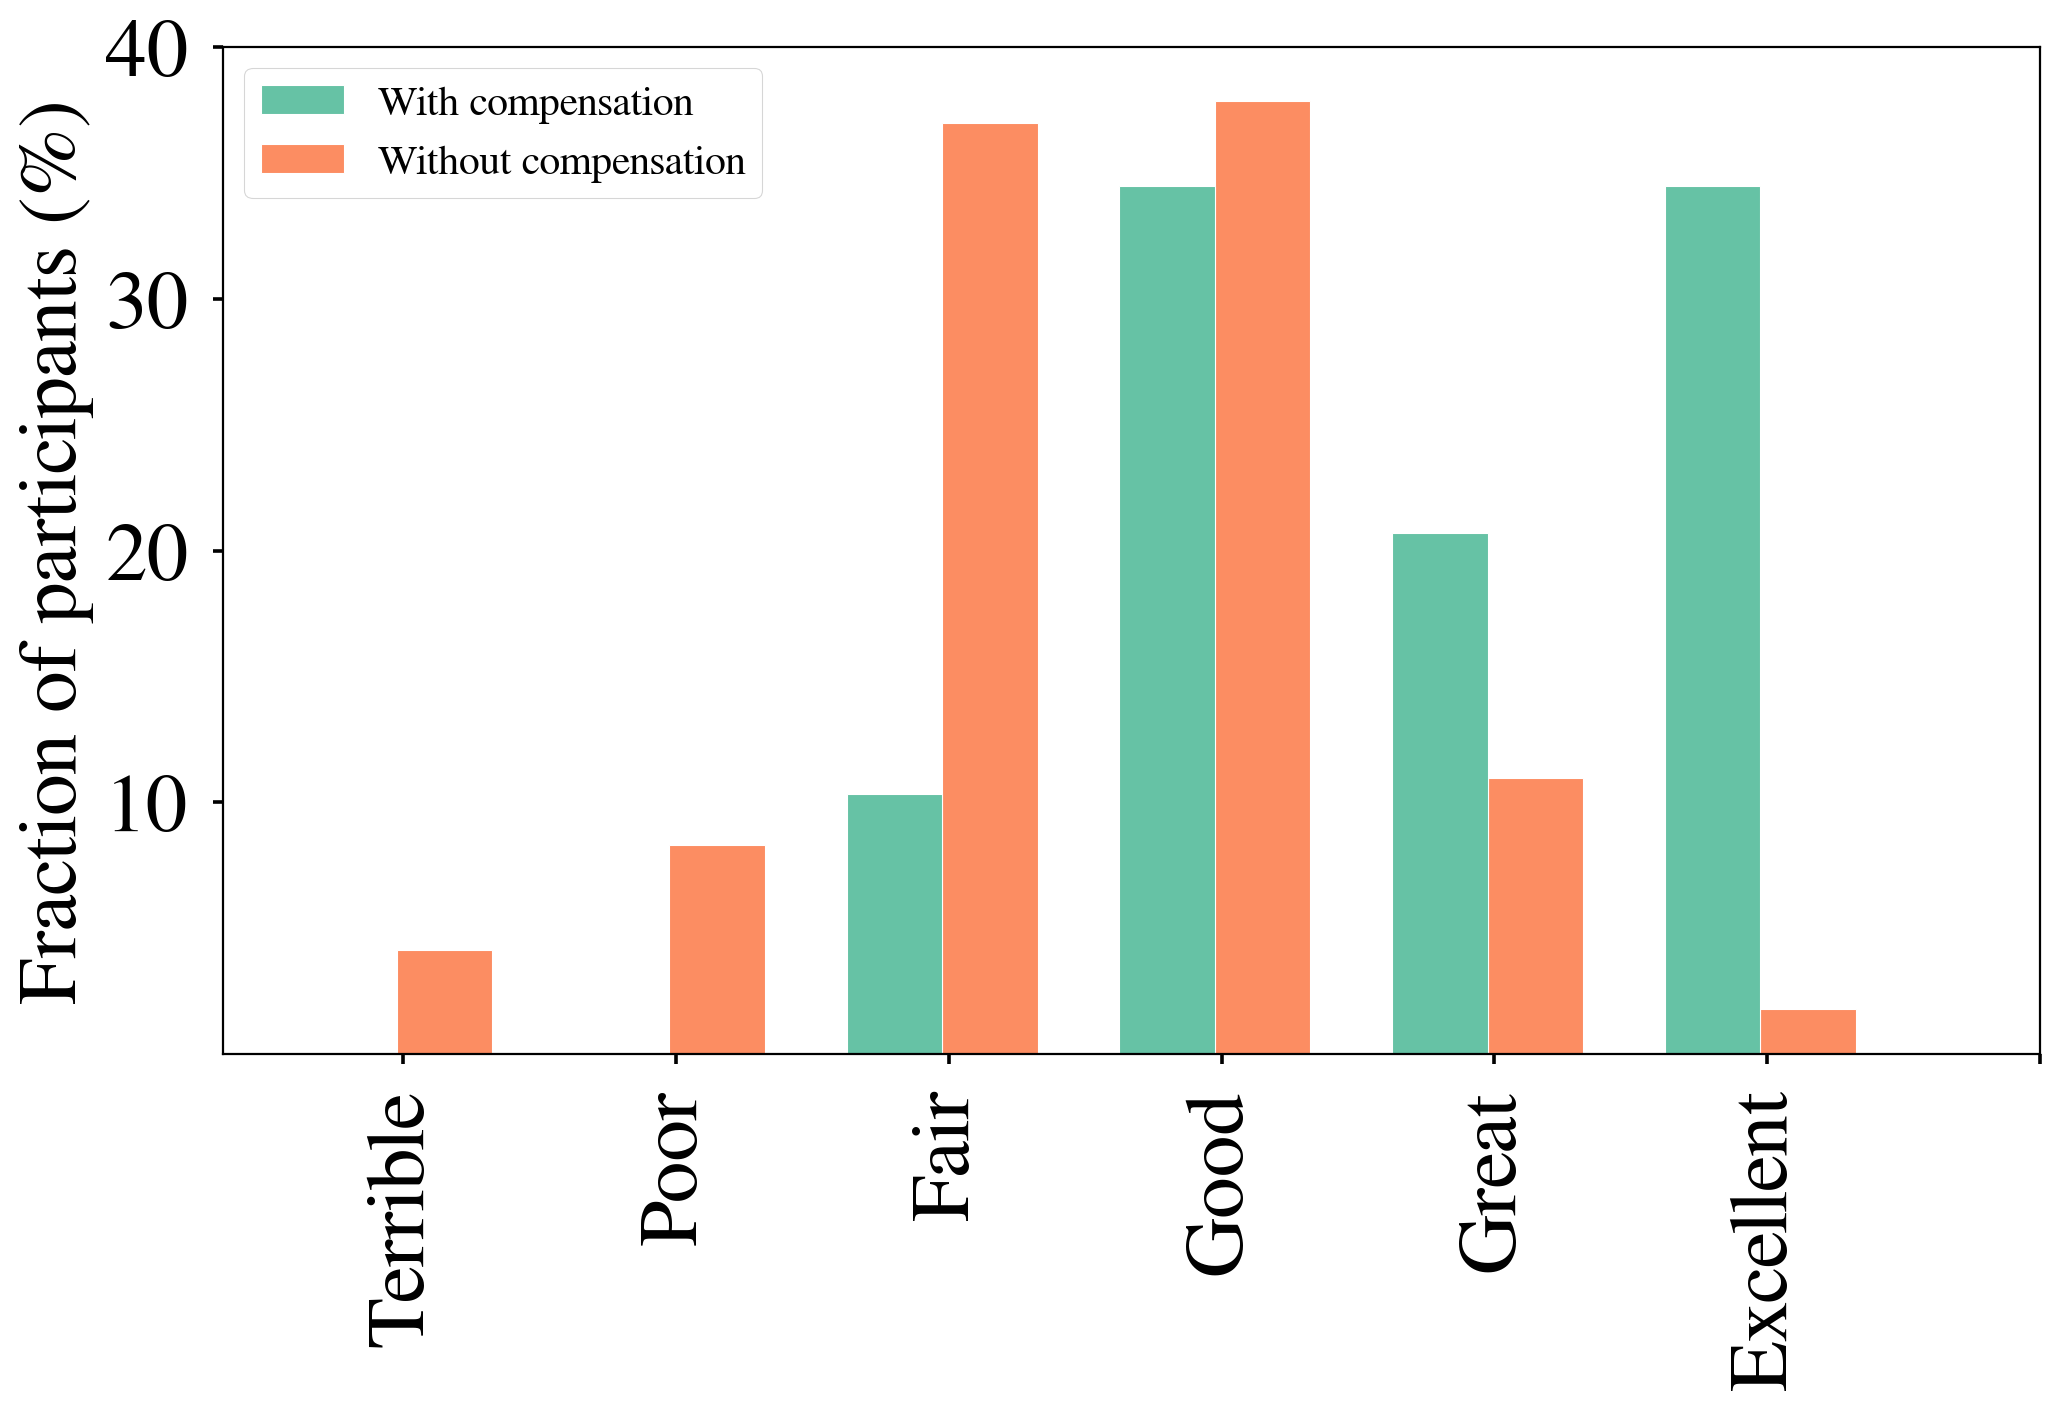

In [10]:
# More authentic results -- hypothesis testing
qids1 = np.array(data_pd[data_pd['compensation'] == 1]['mood'])
qids2 = np.array(data_pd[data_pd['compensation'] == 0]['mood'])


mw_stat, mw_pval = stats.mannwhitneyu(qids1, qids2, alternative='greater')
tt_stat, tt_pval = stats.ttest_ind(qids1, qids2, equal_var=False)
    
print('With: %.2f +/- %.2f'%(qids1.mean(), np.sqrt(qids1.var())))
print('Without: %.2f +/- %.2f'%(qids2.mean(), np.sqrt(qids2.var())))
    
print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
print('t-test: stat: %.2f; pval: %.6f'%(tt_stat, tt_pval))

fig = plt.figure(dpi=200)
bins = np.arange(7)
plt.hist(qids1, bins=bins-0.35, ec='white', alpha=1, rwidth=0.35, align='left',
         label='With compensation', zorder=1, density=True, histtype='bar')
plt.hist(qids2, bins=bins, ec='white', alpha=1, rwidth=0.35, align='left',
         label='Without compensation', zorder=0, density=True, histtype='bar')

plt.xticks(bins-0.15, labels=['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'], rotation='vertical', fontsize=30)
plt.yticks([0.1, 0.2, 0.3, 0.4], labels=['10', '20', '30', '40'], fontsize=30)
plt.ylabel('Fraction of participants (%)', fontsize=30)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('%s/hist_healthcare_compensation.pdf'%saveroot)
plt.show()

In [11]:
# Custom burnout scores
const = 60*60*24*12

qids_ids = [key for key in db if \
            len(db[key]['K']) > 1 and \
            db[key]['state'] == 'Texas' and \
            #len(db[key]['pre_physical']) > 0 and\
            #'None' not in db[key]['pre_physical'] and\
            #'none of the above' not in db[key]['pre_physical'] and\
            #'(empty)' not in db[key]['pre_physical']]
            db[key]['healthcare_worker']]

mood_dict = {key:db[key] for key in qids_ids}
print(len(mood_dict))

data_dict = {'burnout0': [],
             'burnout1': [],
             'nresponses': [],
             'timestamp': [],
             'timestring': [],
             'timestring2': [],
             'gender': []}

for key in mood_dict:
    K_panels = mood_dict[key]['K']

    for K_panel in K_panels:
        time_stamp = const*(K_panel['timestamp']//const)
        data_dict['timestamp'].append(time_stamp)
        data_dict['nresponses'].append(1)
        #if mood_dict[key]['age'] <= 40:
        #    b0 = K_panel['burnout']
        #    b1 = float('Nan')
        #else:
        #    b1 = K_panel['burnout']
        #    b0 = float('Nan')
        if mood_dict[key]['country'] == 'United States of America':
            b0 = K_panel['burnout']
            b1 = float('Nan')
        else:
            b0 = float('Nan')
            b1 = K_panel['burnout']
            
        data_dict['burnout0'].append(b0)
        data_dict['burnout1'].append(b1)
        
        data_dict['timestring'].append(d2s(time_stamp*1000))
        data_dict['timestring2'].append(d2s2(time_stamp*1000))
        data_dict['gender'].append(mood_dict[key]['gender'])

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')


49


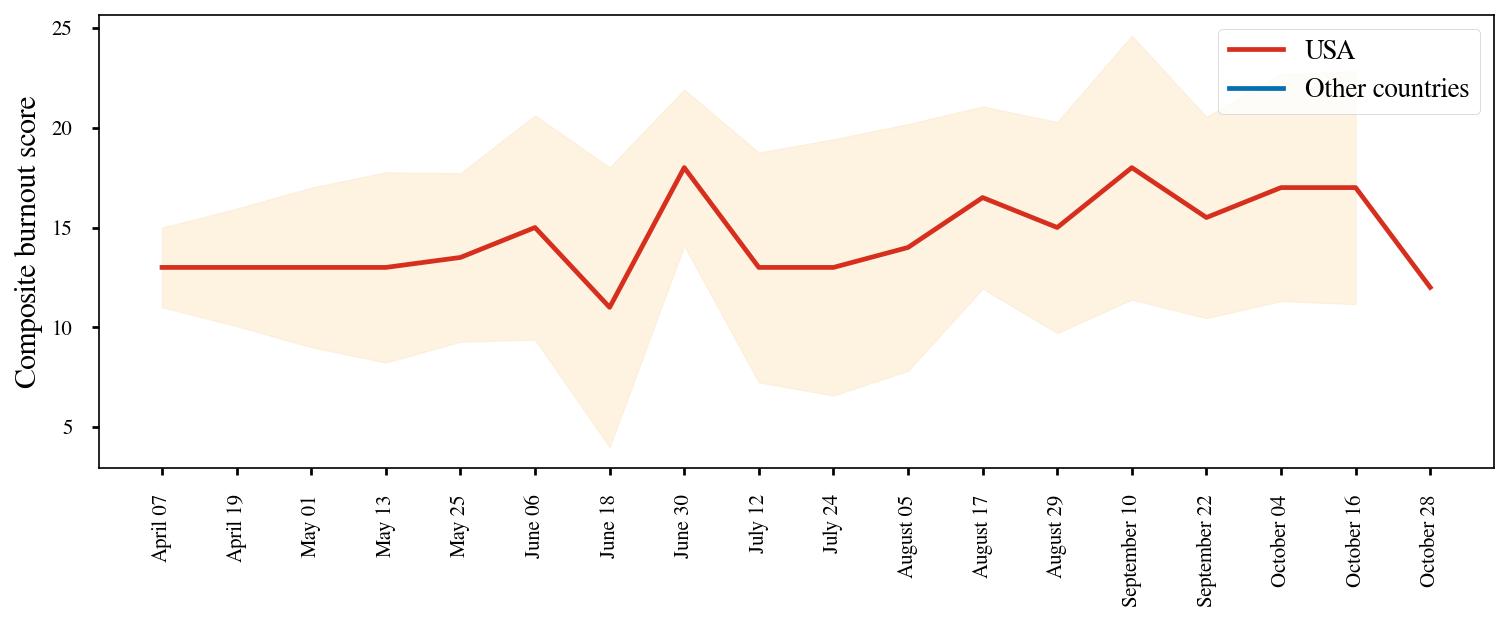

In [12]:
# Mood averaging a la Ashok
fig, ax, _ = utils.plot_timeseries(data_pd, 'burnout0', palette='OrRd', label='USA')
fig, ax, _ = utils.plot_timeseries(data_pd, 'burnout1', fig=fig, ax=ax, palette='PuBu', label='Other countries')

plt.ylabel('Composite burnout score')
plt.legend()

plt.show()

2
No substance usage change: 4615
Substance usage change: 1535


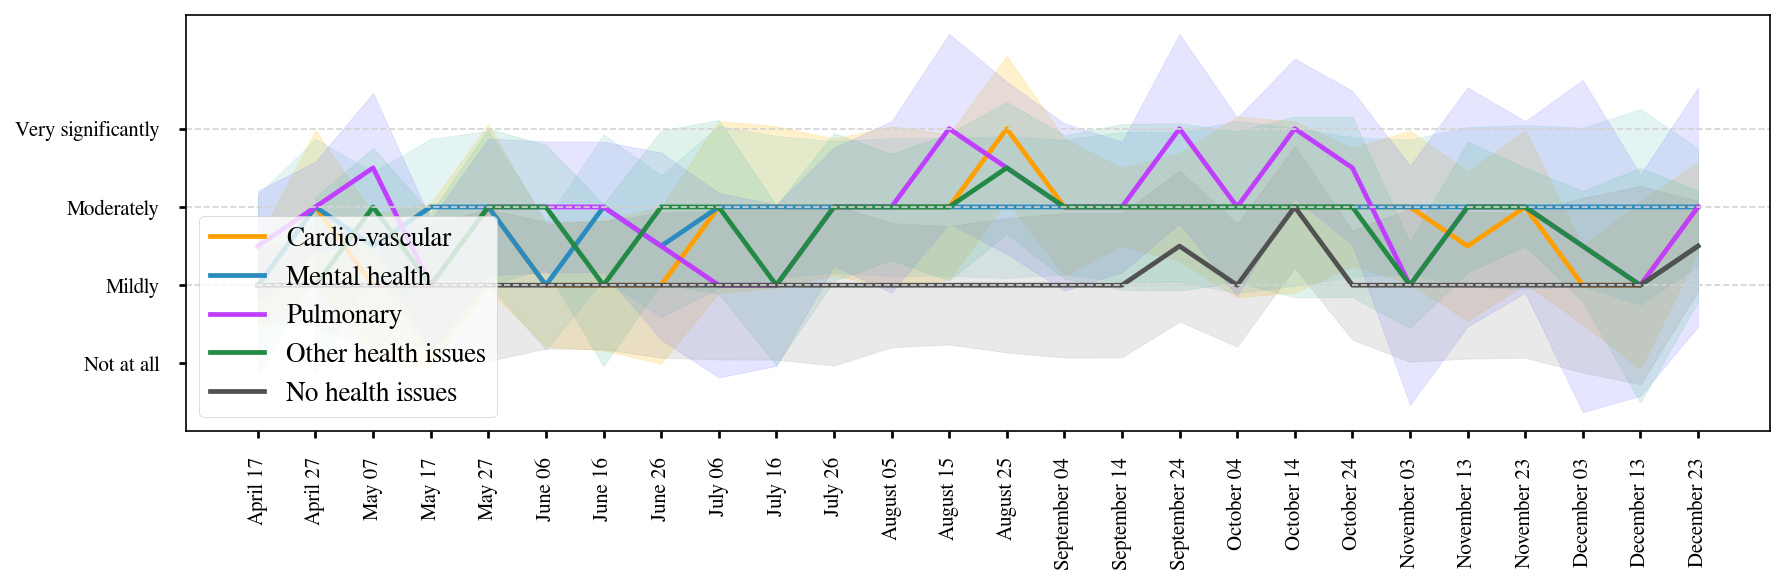

In [76]:
# Do a time series for news articles
const = 60*60*24*10
substance_gate = True

news_keys = [key for key in db if len(db[key]['news']) > 0]

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = int(datetime.date.today().strftime('%S'))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%m %d')
d2s2 = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

data_dict = {'news': [],
             'news_accuracy': [],
             'news_stress': [],
             'news_mental_health': [],
             'news_adequate': [],
             'enjoy_present': [],
             'worried_about': [],
             'timestring': [],
             'timestring2': [],
             'gender': [],
             'healthcare_worker': [],
             'timestamp': [],
             'nresponses': [],
             'None': [],
             'Mental health': [],
             'Cardio-vascular': [],
             'Pulmonary': [],
             'Other health issues': [],
             'country': [],
             'compensation': [],
             'substance': [],
             'sleep_without_substance': []}
dict_keys = ['news', 'news_accuracy', 'news_stress','news_mental_health',
             'enjoy_present', 'worried_about', 'news_adequate', 'substance',
             'sleep_without_substance']

for key in news_keys:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']
    for news_info in db[key]['news']:
        timestamp = const * (news_info['timestamp'] // const)
        for news_key in dict_keys:
            try:
                data_dict[news_key].append(news_info[news_key])
            except KeyError:
                data_dict[news_key].append(float('Nan'))
        
        if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
            len(set(conversion_dict['None']).intersection(mental)) > 0:
            data_dict['None'].append(1)
            data_dict['Mental health'].append(0)
            data_dict['Cardio-vascular'].append(0)
            data_dict['Pulmonary'].append(0)
            data_dict['Other health issues'].append(0)
        else:
            data_dict['None'].append(0)
            if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
                data_dict['Mental health'].append(1)
            else:
                data_dict['Mental health'].append(0)
            for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
                if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                    data_dict[condition_name].append(1)
                else:
                    data_dict[condition_name].append(0)
            
        if 'healthcare_extra_compensation' in db[key]:
            data_dict['compensation'] = db[key]['healthcare_extra_compensation']
        else:
            data_dict['compensation'] = float('Nan')
            
        data_dict['nresponses'].append(1)
        data_dict['country'].append(db[key]['country'])
        data_dict['timestring'].append(d2s(timestamp*1000))
        data_dict['timestring2'].append(d2s2(timestamp*1000))
        data_dict['gender'].append(db[key]['gender'])
        data_dict['healthcare_worker'].append(db[key]['healthcare_worker'])
        data_dict['timestamp'].append(timestamp)

data_pd = pd.DataFrame.from_dict(data_dict).sort_values(by='timestamp')

print(max(data_dict['sleep_without_substance']))
print('No substance usage change: %d'%len(data_pd[data_pd['substance'] == 0]))
print('Substance usage change: %d'%len(data_pd[data_pd['substance'] != 0]))

if substance_gate:
    thres = 0
    affix = 'substance_gate'
else:
    thres = 10
    affix = 'full'

varname = 'news_mental_health'
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['Cardio-vascular'] == 1)*(data_pd['substance'] != thres)],
                                varname, palette='Wistia', label='Cardio-vascular')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['Mental health'] == 1)*(data_pd['substance'] != thres)],
                                varname, fig=fig, ax=ax, palette='GnBu', label='Mental health')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['Pulmonary'] == 1)*(data_pd['substance'] != thres)],
                                varname, fig=fig, ax=ax, palette='cool', label='Pulmonary')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['Other health issues'] == 1)*(data_pd['substance'] != 0)],
                                varname, fig=fig, ax=ax, palette='BuGn', label='Other health issues')
fig, ax, init = utils.plot_timeseries(data_pd[(data_pd['None'] == 1)*(data_pd['substance'] != thres)],
                                varname, fig=fig, ax=ax, palette='Greys', label='No health issues')
plt.legend(loc='lower left')
if varname == 'news_mental_health':
    plt.yticks([0, 1, 2, 3], labels=['Not at all', 'Mildly', 'Moderately', 'Very significantly'])
    #plt.ylabel('News affecting mental health')

    plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=3.0, linestyle='--', color='lightgray', linewidth=0.8)
elif varname == 'substance' or varname == 'sleep_without_substance':
    plt.yticks([-2, -1, 0, 1, 2], labels=['Significantly less than before',
                                          'Slightly less than before',
                                          'Same as before', 
                                          'Slightly more than before', 
                                          'Significantly more than before'])
    #if varname == 'substance':
    #    plt.ylabel('Substance usage compared to normal')
    #else:
    #    plt.ylabel('Incrase in substance usage to sleep, compared to normal')
    plt.axhline(y=-2.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=-1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=0.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=1.0, linestyle='--', color='lightgray', linewidth=0.8)
    plt.axhline(y=2.0, linestyle='--', color='lightgray', linewidth=0.8)

plt.tight_layout()
plt.savefig('%s/%s_preexisting_%s.pdf'%(saveroot, varname, affix), bbox_inches='tight')
plt.show()


In [95]:
interest = 'Pulmonary'
len(data_pd[(data_pd[interest] == 1)*(data_pd['substance'] > 0)])/len(data_pd[data_pd[interest] == 1])

0.16071428571428573

In [125]:
# Max of news affecting mental health, and substance usage

data_dict = {'substance': [],
             'news_mental_health': [],
             'sleep_without_substance': [],
             'None': [],
             'Mental health': [],
             'Cardio-vascular': [],
             'Pulmonary': [],
             'Other health issues': []
             }

for key in db:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']

    substance_array = [arr['substance'] for arr in db[key]['news'] if 'substance' in arr]
    sleep_array = [arr['sleep_without_substance'] for arr in db[key]['news'] if 'sleep_without_substance' in arr]
    news_array = [arr['news_mental_health'] for arr in db[key]['news'] if 'news_mental_health' in arr]

    if len(substance_array) > 0:
        data_dict['substance'].append(max(substance_array))
    else:
        data_dict['substance'].append(float('nan'))

    if len(sleep_array) > 0:
        data_dict['sleep_without_substance'].append(max(sleep_array))
    else:
        data_dict['sleep_without_substance'].append(float('nan'))

    if len(news_array) > 0:
        data_dict['news_mental_health'].append(max(news_array))
    else:
        data_dict['news_mental_health'].append(float('nan'))
    
    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
        len(set(conversion_dict['None']).intersection(mental)) > 0:
        data_dict['None'].append(1)
        data_dict['Mental health'].append(0)
        data_dict['Cardio-vascular'].append(0)
        data_dict['Pulmonary'].append(0)
        data_dict['Other health issues'].append(0)
    else:
        data_dict['None'].append(0)
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            data_dict['Mental health'].append(1)
        else:
            data_dict['Mental health'].append(0)
        for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
            if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                data_dict[condition_name].append(1)
            else:
                data_dict[condition_name].append(0)

data_pd = pd.DataFrame.from_dict(data_dict)
interest = 'Mental health'
varname = 'news_mental_health'
print(len(data_pd[(data_pd[varname] > 2)*(data_pd[interest] == 1)])/len(data_pd[data_pd[interest] == 1]))

0.25865580448065173


4615
6150


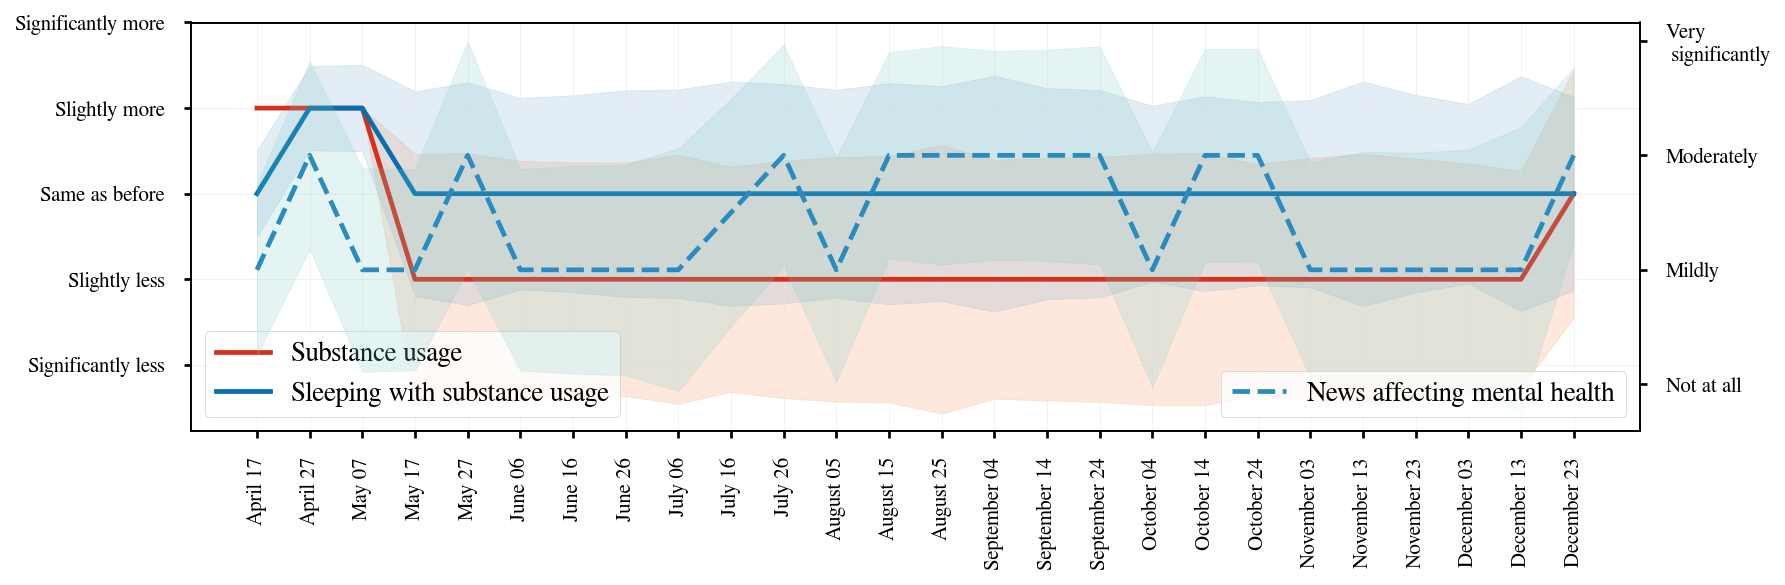

In [25]:

fig, ax, _ = utils.plot_timeseries(data_pd[data_pd['substance'] != 0], 'substance', palette='OrRd', label='Substance usage')
fig, ax, _ = utils.plot_timeseries(data_pd[data_pd['substance'] != 0], 'sleep_without_substance', fig=fig, ax=ax, palette='PuBu', label='Sleeping with substance usage')

print(len(data_pd[data_pd['substance'] == 0]))
print(len(data_pd))

ax2 = ax.twinx()
fig, ax2, _ = utils.plot_timeseries(data_pd[data_pd['substance'] != 0], 'news_mental_health', fig=fig, ax=ax2, palette='GnBu', label='News affecting mental health',
                                    linestyle='--')
#sns.regplot(x='substance', y='mood', data=data_pd,
#                x_jitter=np.random.randn(len(data_pd))/10,
#                y_jitter=np.random.randn(len(data_pd))/10)
#sns.jointplot(x='substance', y='mood', data=data_pd[data_pd['substance'] != 0].dropna(), kind='hex')

ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(["Significantly less", 'Slightly less', 'Same as before', 'Slightly more', 'Significantly more'])

ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['Not at all', 'Mildly', 'Moderately', 'Very\n significantly'])
ax.grid(color=(0.9, 0.9, 0.9), linewidth=0.25)
ax.legend(loc='lower left')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.savefig('%s/substance_vs_news.pdf'%saveroot)
plt.show()

In [11]:
# More authentic results -- hypothesis testing
subdb = data_pd[data_pd['healthcare_worker'] == 1].dropna()

qids1 = np.array(data_pd[data_pd['compensation'] == 1]['news_mental_health'])
qids2 = np.array(data_pd[data_pd['compensation'] == 0]['news_mental_health'])

print(qids1)
print(qids2)

mw_stat, mw_pval = stats.mannwhitneyu(qids1, qids2, alternative='greater')
tt_stat, tt_pval = stats.ttest_ind(qids1, qids2, equal_var=False)
    
print('With: %.2f +/- %.2f'%(qids1.mean(), np.sqrt(qids1.var())))
print('Without: %.2f +/- %.2f'%(qids2.mean(), np.sqrt(qids2.var())))
    
print('Mann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
print('t-test: stat: %.2f; pval: %.6f'%(tt_stat, tt_pval))

[]
[]
With: nan +/- nan
Without: nan +/- nan
Mann-Whitney U: stat: 0.00; pval: 1.000000
t-test: stat: nan; pval: nan


In [27]:
const = 60*60*24*10

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = datetime.datetime(2020, 12, 31, 0, 0).timestamp()

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}

camsr_dict = {key:[] for key in conversion_dict}
ipip_dict = {key:[] for key in conversion_dict}
qids_dict = {key:[] for key in conversion_dict}

for key in db:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']

    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
       len(set(conversion_dict['None']).intersection(mental)) > 0:
        if 'camsr' in db[key]:
            camsr_dict['None'].append(db[key]['camsr'])
        if 'ipip' in db[key]:
            ipip_dict['None'].append(db[key]['ipip'])
        if len(db[key]['QIDS']) > 0:
            for qkey, qval in db[key]['QIDS'].items():
                if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                    qids_dict['None'].append(qval)
    else:            
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            if 'camsr' in db[key]:
                camsr_dict['Mental health'].append(db[key]['camsr'])
            if 'ipip' in db[key]:
                ipip_dict['Mental health'].append(db[key]['ipip'])
            if len(db[key]['QIDS']) > 0:
                for qkey, qval in db[key]['QIDS'].items():
                    if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                        qids_dict['Mental health'].append(qval)
        for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
            if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                if 'camsr' in db[key]:
                    camsr_dict[condition_name].append(db[key]['camsr'])
                if 'ipip' in db[key]:
                    ipip_dict[condition_name].append(db[key]['ipip'])
                if len(db[key]['QIDS']) > 0:
                    for qkey, qval in db[key]['QIDS'].items():
                        if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                            qids_dict[condition_name].append(qval)


4044.0, 1599099330.0, 1601722550.0, 1602562442.0, 1604296240.0, 1597393248.0, 1603425600.0, 1600837267.0, 1590381143.0, 1590116110.0, 1590978730.0, 1592781882.0, 1597901394.0, 1601352921.0, 1595297273.0, 1597033476.0, 1594097448.0, 1595028198.0, 1599453534.0, 1598405492.0, 1596685198.0, 1595823566.0, 1591842351.0, 1591931803.0, 1594520975.0, 1596260878.0, 1603166151.0, 1600578678.0, 1599714944.0, 1597111723.0, 1604032572.0, 1594846052.0, 1592109262.0, 1593885989.0, 1595569005.0, 1598155559.0, 1597299146.0, 1599112957.0, 1603342355.0, 1602529157.0, 1601670039.0, 1604207379.0, 1594191774.0, 1593321158.0, 1595044675.0, 1594252827.0, 1602963628.0, 1598499635.0, 1597643077.0, 1596777436.0, 1593302467.0, 1594972285.0, 1591066386.0, 1594705925.0, 1594645123.0, 1597202979.0, 1594096416.0, 1595025518.0, 1602743152.0, 1596692118.0, 1604463212.0, 1603597364.0, 1592192656.0, 1593060481.0, 1594093718.0, 1594180705.0, 1595045396.0, 1602817761.0, 1603687811.0, 1596878335.0, 1594861867.0, 1594006767.0